# TSNE Resolve Colors Bug Documentation

Jerome Massot reports that there is a bug in TSNE that mixes colors and labels if y is passed in the fit() and not the constructor.

In this example, we'll validate that the bug exists, and that his proposed solution works

In [3]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import numpy as np
import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt

## Validate Bug

In [11]:
from yellowbrick.download import download_all 
from sklearn.datasets.base import Bunch

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "hobbies": os.path.join(FIXTURES, "hobbies")
}

def load_data(name, download=True):
    """
    Loads and wrangles the passed in text corpus by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            with open(os.path.join(path, cat, name), 'r', errors='ignore') as f:
                data.append(f.read())
        
    
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

In [46]:
import numpy as np

from collections import defaultdict

from yellowbrick.draw import manual_legend
from yellowbrick.text.base import TextVisualizer
from yellowbrick.style.colors import resolve_colors
from yellowbrick.exceptions import YellowbrickValueError

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA

##########################################################################
## TSNEVisualizer
##########################################################################
class TSNEVisualizer(TextVisualizer):
    NULL_CLASS = None

    def __init__(self, ax=None, decompose='svd', decompose_by=50,
                 labels=None, classes=None, colors=None, colormap=None,
                 random_state=None, alpha=0.7, **kwargs):

        # Visual Parameters
        self.alpha = alpha
        self.labels = labels
        self.colors = colors
        self.colormap = colormap
        self.random_state = random_state

        # Fetch TSNE kwargs from kwargs by popping only keys belonging to TSNE params
        tsne_kwargs = {
            key: kwargs.pop(key)
            for key in TSNE().get_params()
            if key in kwargs
        }
        self.transformer_ = self.make_transformer(decompose, decompose_by, tsne_kwargs)

        # Call super at the end so that size and title are set correctly
        super(TSNEVisualizer, self).__init__(ax=ax, **kwargs)

    def make_transformer(self, decompose='svd', decompose_by=50, tsne_kwargs={}):
        decompositions = {
            'svd': TruncatedSVD,
            'pca': PCA,
        }

        if decompose and decompose.lower() not in decompositions:
            raise YellowbrickValueError(
                "'{}' is not a valid decomposition, use {}, or None".format(
                    decompose, ", ".join(decompositions.keys())
                )
            )

        # Create the pipeline steps
        steps = []
        # Add the pre-decomposition
        if decompose:
            klass = decompositions[decompose]
            steps.append((decompose, klass(
                n_components=decompose_by, random_state=self.random_state)))

        # Add the TSNE manifold
        steps.append(('tsne', TSNE(
            n_components=2, random_state=self.random_state, **tsne_kwargs)))

        # return the pipeline
        return Pipeline(steps)

    def fit(self, X, y=None, **kwargs):
        # Store the classes we observed in y
        if y is not None:
            self.classes_ = np.unique(y)
        elif y is None and self.labels is not None:
            self.classes_ = np.array([self.labels[0]])
        else:
            self.classes_ = np.array([self.NULL_CLASS])

        # Fit our internal transformer and transform the data.
        vecs = self.transformer_.fit_transform(X)
        self.n_instances_ = vecs.shape[0]

        # Draw the vectors
        self.draw(vecs, y, **kwargs)

        # Fit always returns self.
        return self
    
    def draw(self, points, target=None, **kwargs):
        # Resolve the labels with the classes
        labels = self.labels if self.labels is not None else self.classes_
        if len(labels) != len(self.classes_):
            raise YellowbrickValueError((
                "number of supplied labels ({}) does not "
                "match the number of classes ({})"
            ).format(len(labels), len(self.classes_)))


        # Create the color mapping for the labels.
        self.color_values_ = resolve_colors(
            n_colors=len(labels), colormap=self.colormap, colors=self.colors)
        colors = dict(zip(labels, self.color_values_))

        # Transform labels into a map of class to label
        labels = dict(zip(self.classes_, labels))

        # Expand the points into vectors of x and y for scatter plotting,
        # assigning them to their label if the label has been passed in.
        # Additionally, filter classes not specified directly by the user.
        series = defaultdict(lambda: {'x':[], 'y':[]})

        if target is not None:
            for t, point in zip(target, points):
                label = labels[t]
                series[label]['x'].append(point[0])
                series[label]['y'].append(point[1])
        else:
            label = self.classes_[0]
            for x,y in points:
                series[label]['x'].append(x)
                series[label]['y'].append(y)

        # Plot the points
        for label, points in series.items():
            self.ax.scatter(
                points['x'], points['y'], c=colors[label],
                alpha=self.alpha, label=label
            )
            
    def finalize(self, **kwargs):
        self.set_title(
            "TSNE Projection of {} Documents".format(self.n_instances_)
        )

        # Remove the ticks
        self.ax.set_yticks([])
        self.ax.set_xticks([])

        # Add the legend outside of the figure box.
        if not all(self.classes_ == np.array([self.NULL_CLASS])):
            box = self.ax.get_position()
            self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            manual_legend(
                self, self.classes_, self.color_values_,
                loc='center left', bbox_to_anchor=(1, 0.5)
            )

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = load_data('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(corpus.data)
labels = corpus.target

colors=["red","blue","green","yellow","black"]

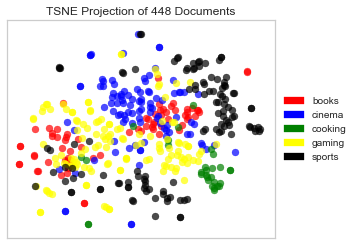

In [108]:
tsne = TSNEVisualizer(colors=colors)
tsne.fit(docs, labels)
tsne.poof()

In [109]:
tsne = TSNEVisualizer(colors=colors, labels=labels)
tsne.fit(docs)
tsne.poof()

YellowbrickValueError: number of supplied labels (448) does not match the number of classes (1)

## Validate Solution

In [169]:
##########################################################################
## TSNEVisualizer Fixed
##########################################################################
class TSNEVisualizer_fixed(TextVisualizer):
    NULL_CLASS = None

    def __init__(self, ax=None, decompose='svd', decompose_by=50,
                 labels=None, classes=None, colors=None, colormap=None,
                 random_state=None, alpha=0.7, **kwargs):

        # Visual Parameters
        self.alpha = alpha
        self.labels = labels
        self.colors = colors
        self.colormap = colormap
        self.random_state = random_state

        # Fetch TSNE kwargs from kwargs by popping only keys belonging to TSNE params
        tsne_kwargs = {
            key: kwargs.pop(key)
            for key in TSNE().get_params()
            if key in kwargs
        }
        self.transformer_ = self.make_transformer(decompose, decompose_by, tsne_kwargs)
    
        # Call super at the end so that size and title are set correctly
        super(TSNEVisualizer_fixed, self).__init__(ax=ax, **kwargs)

    def make_transformer(self, decompose='svd', decompose_by=50, tsne_kwargs={}):
        decompositions = {
            'svd': TruncatedSVD,
            'pca': PCA,
        }

        if decompose and decompose.lower() not in decompositions:
            raise YellowbrickValueError(
                "'{}' is not a valid decomposition, use {}, or None".format(
                    decompose, ", ".join(decompositions.keys())
                )
            )

        # Create the pipeline steps
        steps = []
        # Add the pre-decomposition
        if decompose:
            klass = decompositions[decompose]
            steps.append((decompose, klass(
                n_components=decompose_by, random_state=self.random_state)))

        # Add the TSNE manifold
        steps.append(('tsne', TSNE(
            n_components=2, random_state=self.random_state, **tsne_kwargs)))

        # return the pipeline
        return Pipeline(steps)

    def fit(self, X, y=None, **kwargs):
        # Store the classes we observed in y
        if y is not None:
            indexes = np.unique(y, return_index=True)[1]
            self.classes_ = [y[index] for index in sorted(indexes)]
        elif y is None and self.labels is not None:
            indexes = np.unique(self.labels, return_index=True)[1]
            self.classes_ = [self.labels[index] for index in sorted(indexes)]
        else:
            self.classes_ = np.array([self.NULL_CLASS])

        # Fit our internal transformer and transform the data.
        vecs = self.transformer_.fit_transform(X)
        self.n_instances_ = vecs.shape[0]

        # Draw the vectors
        self.draw(vecs, y, **kwargs)

        # Fit always returns self.
        return self
    
    def draw(self, points, target=None, **kwargs):
        # Resolve the labels with the classes
        labels = np.unique(self.labels) if self.labels is not None else self.classes_
        if len(labels) != len(self.classes_):
            raise YellowbrickValueError((
                "number of supplied labels ({}) does not "
                "match the number of classes ({})"
            ).format(len(labels), len(self.classes_)))


        # Create the color mapping for the labels.
        self.color_values_ = resolve_colors(
            n_colors=len(labels), colormap=self.colormap, colors=self.colors)
        colors = dict(zip(labels, self.color_values_))

        # Transform labels into a map of class to label
        labels = dict(zip(self.classes_, labels))

        # Expand the points into vectors of x and y for scatter plotting,
        # assigning them to their label if the label has been passed in.
        # Additionally, filter classes not specified directly by the user.
        series = defaultdict(lambda: {'x':[], 'y':[]})

        if target is not None:
            for t, point in zip(target, points):
                label = labels[t]
                series[label]['x'].append(point[0])
                series[label]['y'].append(point[1])
            ## DEGUG -- TO BE REMOVED ############
            for label in labels:
                print(len(series[label]['x']))
            ######################################
        else:
            for t, point in zip(self.labels, points):
                label = labels[t]
                series[label]['x'].append(point[0])
                series[label]['y'].append(point[1])
            ## DEGUG -- TO BE REMOVED ############
            for label in labels:
                print(len(series[label]['x']))
            ######################################
        # Plot the points
        for label, points in series.items():
            self.ax.scatter(
                points['x'], points['y'], c=colors[label],
                alpha=self.alpha, label=label
            )
            
    def finalize(self, **kwargs):
        self.set_title(
            "TSNE Projection of {} Documents".format(self.n_instances_)
        )

        # Remove the ticks
        self.ax.set_yticks([])
        self.ax.set_xticks([])

        # Add the legend outside of the figure box.
        if not all(self.classes_ == np.array([self.NULL_CLASS])):
            box = self.ax.get_position()
            self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            manual_legend(
                self, self.classes_, self.color_values_,
                loc='center left', bbox_to_anchor=(1, 0.5)
            )

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = load_data('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(corpus.data)
labels = corpus.target

## DEGUG -- TO BE REMOVED ############
for label in np.unique(labels):
    lab = [labels[i] for i in range(len(labels)) if labels[i]==label]
    print(len(lab))
######################################

colors=["red","blue","green","yellow","black"]

72
100
30
128
118


72
100
30
128
118


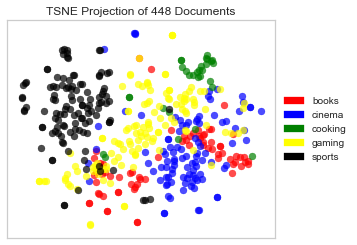

In [167]:
tsne = TSNEVisualizer_fixed(colors=colors)
tsne.fit(docs, labels)
tsne.poof()

72
100
30
128
118


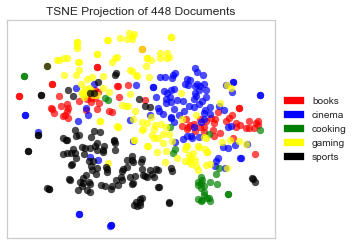

In [168]:
tsne = TSNEVisualizer_fixed(colors=colors, labels=labels)
tsne.fit(docs)
tsne.poof()